# Advanced Machine Learning - programming assignment 4

*Due: Friday January 26*

**Please fill in:**
* name 1 (student id 1)
* name 2 (student id 2)

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set. Each of these two parts is worth 5 points.

The PC algorithm will need to keep track of a PDAG. We will represent this PDAG by a numpy array `G` of booleans.

The matrix `G` represents a graph as follows:
* For all `x`, `G[x,x] == False`
* `G[x,y] == False` and `G[y,x] == False` means: no edge between x and y
* `G[x,y] == True` and `G[y,x] == True` means: an undirected edge x&mdash;y
* `G[x,y] == True` and `G[y,x] == False`means: a directed edge x$\to$y

In [3]:
import numpy as np
import itertools
import graphviz # Install with: conda install python-graphviz

from AML_assignment4_util import *

The graphviz package can draw graphs to different file formats, or show them directly in the notebook. The function `graph_to_graphviz(G, node_names)` (from the file `AML_assignment4_util.py`) converts a numpy array of the form described above to a graph in graphviz format. 

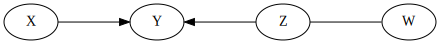

In [4]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a Python class for performing the PC algorithm (when an object of this class is created and its `run` function is called). Add the missing code for phase 2, and implement phases 3 and 4. In the next section, you'll find some test cases to see if your code runs without errors and does what you expect it to.

In [7]:
class PC_algorithm:
    def __init__(self, independence_tester, verbose=1):
        # verbose can be 0 (silent), 1 (report independences), or 2 (also report dependences)
        self.independence_tester = independence_tester
        self.n = independence_tester.n_observed
        self.node_names = independence_tester.node_names
        self.verbose = verbose
        self.G = np.logical_not(np.eye(self.n, dtype=bool))
        self.sepset = dict()
    
    def skeleton_search(self):
        # PHASE II: Skeleton search
        # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
        for k in range(self.n-1):
            for x in range(self.n):
                for y in range(self.n):
                    if not self.G[x,y]:
                        continue
                    # Try all subsets S of Adj(x) \ {y} with |S|=k,
                    # until an independence is found.
                    # Hint: use itertools.combinations

                    # Your code here (1 point)
                    Adj_X = set(np.where(self.G[x])[0]) - {y} #gets the set of adjacent nodes to x, exclusing y.


                    for S in itertools.combinations(Adj_X, k): # from all adjacent nodes to x escluding z, take all combinations of size k
                        indep = self.independence_tester.test_independence(x, y, S)
                        if indep:
                            if self.verbose >= 1:
                                print("independence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))
                            # Remove this edge.
                            self.G[x,y] = self.G[y,x] = False
                            # We use frozensets as keys in the dictionary self.sepset,
                            # because ordinary sets can't be used as keys to dictionaries.
                            self.sepset[frozenset([x,y])] = S
                            break
                        else:
                            if self.verbose >= 2:
                                print("dependence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))

            # Do we need to continue with larger k?
            max_S_size = np.sum(self.G, axis=0) - 1
            if np.all(max_S_size < k + 1):
                break
        return

    def orient_v_structures(self):
        # PHASE III: Orient v-structures
        # Something to watch out for:
        # If the data are not faithful to any graph, the algorithm may end up trying
        # to orient a single edge in two different ways. You can choose either
        # orientation if this happens. But make sure not to accidentally delete such an edge!

        # Your code here (2 points)
        for x in range(self.n):
            for y in range(x+1, self.n): #x+1 makes sure that it does not take the same node as x and y, which would always satisfy the next if statement.
                if not self.G[x,y]: #if not adjacent
                    for z in range(self.n):
                        if self.G[x,z] and self.G[y,z]: #for every node adjacent to both x and y.
                            sepset_xy = self.sepset.get(frozenset([x,y]), set()) #get sepset for x and y.
                            if z not in sepset_xy: #if z is not in the sepset, orient nodes in v_structure.
                                self.G[x, z] = True
                                self.G[y, z] = True
                                self.G[z, x] = False
                                self.G[z, y] = False
                                if self.verbose >= 1: #print independences based on verbose.
                                    print("v_structure found: {0} -> {1}, {2} -> {3}"
                                        .format(self.node_names[x], self.node_names[z], self.node_names[y], self.node_names[z]))    
                                break
        return
    
    def orientation_rules(self):
        # PHASE IV: Orientation rules

        # Your code here (2 points)
        while True: #repeat until
            made_changes = False

            for x in range(self.n):
                for y in range(self.n):
                    for z in range(self.n):
                        for w in range (self.n):
                            if self.G[x, y] and self.G[y, x]: #for every undirected edge in the graph: 
                                # Rule 1:
                                if not self.G[z, y] and not self.G[y, z]: #no edge between z and y
                                    if self.G[x, y] and self.G[y, x]: #undirected edge between x and y
                                        if self.G[z, x] and not self.G[x, z]: #directed edge between z and x
                                            self.G[x, y] = True
                                            self.G[y, x] = False
                                            made_changes = True
                                
                                # Rule 2:
                                if self.G[x, y] and self.G[y, x]: #undirected edge between x and y
                                    if self.G[x, z] and not self.G[z, x]: #directed edge between x and z
                                        if self.G[z, y] and not self.G[y,z]: #directed edge between z and y
                                            self.G[x, y] = True
                                            self.G[y, x] = False
                                            made_changes = True
                                
                                #Rule 3:
                                if self.G[x, y] and self.G[y, x]: #undirected edge between x and y
                                    if self.G[x, z] and self.G[z, x]: #undirected edge between x and z
                                        if self.G[x, w] and self.G[w, x]: #undirected edge between x and w
                                            if self.G[z, y] and not self.G[y, z]: #directed edge between z and y
                                                if self.G[w, y] and not self.G[y, w]: #directed edge between w and y
                                                    self.G[x, y] = True
                                                    self.G[y, x] = False
                                                    made_changes = True

            if not made_changes:
                break
        
        return

    def run(self):
        # The initialization step has already been performed by the __init__ method.
        # Perform the other phases one by one. Each of the following functions
        # modifies self.G, which represents the graph.
        self.skeleton_search()
        self.orient_v_structures()
        self.orientation_rules()

        return self.G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an *oracle* instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, the PC algorithm will recover the Markov equivalence class of the true graph.

In [8]:
class IndependenceOracle:
    def __init__(self, true_G, node_names, n_observed=None):
        self.G = true_G
        self.n = true_G.shape[0]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.node_names = node_names
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph `G1` we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

dependence found: X and Y given {}
independence found: X and Z given {}
independence found: X and W given {}
dependence found: Y and X given {}
dependence found: Y and Z given {}
dependence found: Y and W given {}
dependence found: Z and Y given {}
dependence found: Z and W given {}
dependence found: W and Y given {}
dependence found: W and Z given {}
dependence found: Y and X given {Z}
dependence found: Y and X given {W}
dependence found: Y and Z given {X}
dependence found: Y and Z given {W}
dependence found: Y and W given {X}
independence found: Y and W given {Z}
dependence found: Z and Y given {W}
dependence found: Z and W given {Y}
v_structure found: X -> Y, Z -> Y
PASS


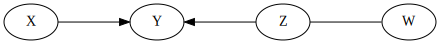

In [9]:
oracle = IndependenceOracle(G1, node_names)
A = PC_algorithm(oracle, verbose=2)
G = A.run()
print("PASS" if np.all(G == G1) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

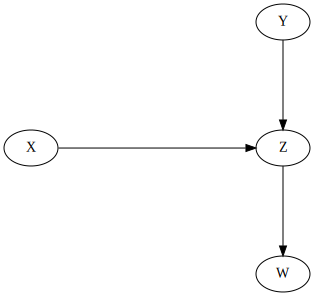

In [10]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: X and Y given {}
independence found: X and W given {Z}
independence found: Y and W given {Z}
v_structure found: X -> Z, Y -> Z
PASS


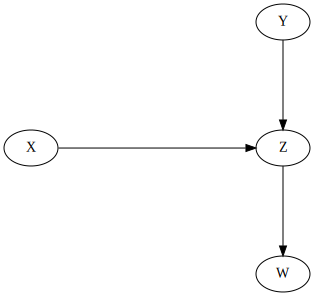

In [11]:
oracle = IndependenceOracle(G2, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G2) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

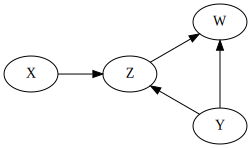

In [12]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: X and Y given {}
independence found: W and X given {Y, Z}
v_structure found: X -> Z, Y -> Z
PASS


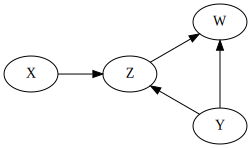

In [13]:
oracle = IndependenceOracle(G3, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G3) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

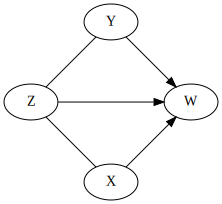

In [14]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: X and Y given {Z}
v_structure found: X -> W, Y -> W
PASS


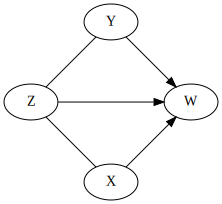

In [15]:
oracle = IndependenceOracle(G4, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G4) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

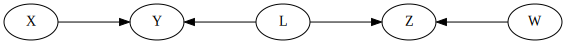

In [16]:
# Example of a case for which no DAG exists that is Markov and faithful to the distribution.
# L is a latent variable that the PC algorithm won't know about. PC's output should be either
# X --> Y --> Z <-- W or
# X --> Y <-- Z <-- W.
# If there is no edge between Y and Z in your output, this most likely indicates a bug in
# your implementation of phase III.
G5 = np.zeros((5,5), dtype=bool)
G5[0,1] = G5[4,1] = True
G5[3,2] = G5[4,2] = True
graph_to_graphviz(G5, ['X', 'Y', 'Z', 'W', 'L'])

independence found: X and Z given {}
independence found: X and W given {}
independence found: Y and W given {}
v_structure found: X -> Y, Z -> Y
PASS


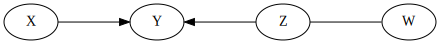

In [17]:
oracle = IndependenceOracle(G5, node_names, n_observed = 4)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if G[0,1] and G[3,2] and (G[1,2] or G[2,1]) and np.sum(np.logical_or(G, G.T)) == 6 else "FAIL")
graph_to_graphviz(G, oracle.node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled `experiment`, indicates in which way that cell was prepared. We can think of `experiment=1` as denoting the observational data, and other values of `experiment` (2 through 14) as various interventional datasets.

In [18]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking the logarithm of 10 + the original value
all_data.loc[:, all_data.columns != 'experiment'] = np.log(10 + all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [20]:
# Your code here (0.5 point)
obs_data = all_data[all_data['experiment'] == 1].copy()
obs_data.drop('experiment', axis = 1, inplace=True)
print(obs_data.shape)


(853, 11)


To run the PC algorithm on data, we need to perform (conditional) independence tests. The code below implements a simple test (based on [partial correlation](https://en.wikipedia.org/wiki/Partial_correlation)). It assumes the data come from a linear structural causal model, which they actually don't. We will use it anyway, because the alternatives (such as `CMIknn` (Runge, 2018)) are orders of magnitude slower, while partial correlation usually already gives decent results.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [21]:
import math
from scipy.stats import beta

class IndependenceTester:
    def __init__(self, data, alpha, verbose=2, n_observed=None):
        # data: a pandas dataframe
        # alpha: the significance level to which the p-values are compared
        
        self.covariance_matrix = np.cov(data, rowvar=False, bias=True)
        self.num_samples = data.shape[0]
        self.n = data.shape[1]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.verbose = verbose
        self.node_names = data.columns
        self.alpha = alpha
    def test_independence(self, x, y, S):
        # Compute the partial correlation of x and y given S by inverting a submatrix of the covariance matrix.
        xyS = [x, y]
        xyS.extend(S)
        precision_matrix = np.linalg.inv(self.covariance_matrix[np.ix_(xyS, xyS)])
        corr = -precision_matrix[0,1] / math.sqrt(precision_matrix[0,0] * precision_matrix[1,1])
        # Compute the p-value as in the scipy manual for scipy.stats.pearsonr.
        dist = beta(self.num_samples / 2 - 1, self.num_samples / 2 - 1, loc=-1, scale=2)
        pval = 2 * dist.cdf(-abs(corr))
        test_result = pval > self.alpha
        if self.verbose >= 2 or (self.verbose >= 1 and test_result):
            print("test: {0} and {1} given {2} -> pval={{{3}}}".format(self.node_names[x], self.node_names[y],
                                                                   ", ".join([self.node_names[v] for v in S]),
                                                                   pval))
        return test_result

Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should either be connected (i.e. consist of one [connected component](https://en.wikipedia.org/wiki/Component_%28graph_theory%29)), or have just two connected components.

test: praf and pmek given  -> pval={6.28314379779454e-129}
dependence found: praf and pmek given {}
test: praf and plcg given  -> pval={0.5373868874563738}
independence found: praf and plcg given {}
test: praf and PIP2 given  -> pval={0.9727919297048809}
independence found: praf and PIP2 given {}
test: praf and PIP3 given  -> pval={0.33465938978893645}
independence found: praf and PIP3 given {}
test: praf and perk given  -> pval={0.6217936401751409}
independence found: praf and perk given {}
test: praf and pakts473 given  -> pval={0.3213233858427666}
independence found: praf and pakts473 given {}
test: praf and PKA given  -> pval={0.9668029258427108}
independence found: praf and PKA given {}
test: praf and PKC given  -> pval={0.20877767649395856}
independence found: praf and PKC given {}
test: praf and P38 given  -> pval={0.09366579153448504}
dependence found: praf and P38 given {}
test: praf and pjnk given  -> pval={0.581956365050984}
independence found: praf and pjnk given {}
test: p

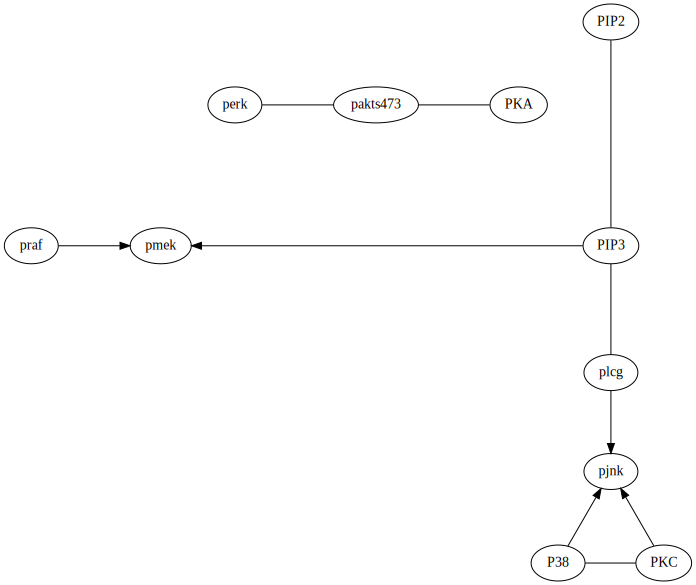

In [27]:
# Your code here (1 point)
i_tester = IndependenceTester(obs_data, alpha=0.1)
A = PC_algorithm(i_tester, verbose=2)
G = A.run()
graph_to_graphviz(G, obs_data.columns)

Now let's look at what else is in the dataset: the interventional data corresponding to different experiments. The PC algorithm did not look at this part of the dataset, but these additional experiments can obviously provide valuable information about the causal graph. In the following questions, we will investigate two examples of this. We will use the output of the PC algorithm that you obtained above to give us a rough idea of what the causal graph might look like. **So don't rerun the algorithm when answering the questions below!**

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [29]:
# Your code here (0.5 point)
psitectorigenin_data = all_data[all_data['experiment'].isin([1,5])].copy()
print(psitectorigenin_data.shape)
U0126_data = all_data[all_data['experiment'].isin([1,6])].copy()
print(U0126_data.shape)


(1663, 12)
(1652, 12)


**Question (1.5 points)**: In the dataframe for experiments 1 and 5, look at PIP2 and a variable adjacent to it in the output of PC (if there is more than one, pick one). Using about 200 words, answer the following questions: Based on looking at one or more plots (like scatterplots or histograms), which do you find more likely: that psitectorigenin directly modifies PIP2, or the neighbouring variable, or both? And what does the data for the two experiments seem to say about the direction of the arrow between PIP2 and its neighbour?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Please put your answer in markdown boxes, not as comments in your code!)


From the plots below, I find it more likely that psitectorigenin directly modifies PIP2, since the relative effect of the treatment is larger on PIP2 than on PIP3. In the histograms you see a sharper decrease of PIP2 values in experiment 5 than you see for PIP3 values. Additionally, you see that almost all PIP2 values are set the the same value of approximately 2.5, while PIP3 has more variance after the treatment, fitting with a direct effect of psitectorigenin on PIP2.

The data seems to indicate that the arrow between PIP2 and PIP3 should be in the direction from PIP2 to PIP3. Looking at the scatterplots, variance would be more equal and less severe if PIP2 would be the cause of PIP 3 compared to when PIP3 would be the cause of PIP2. 

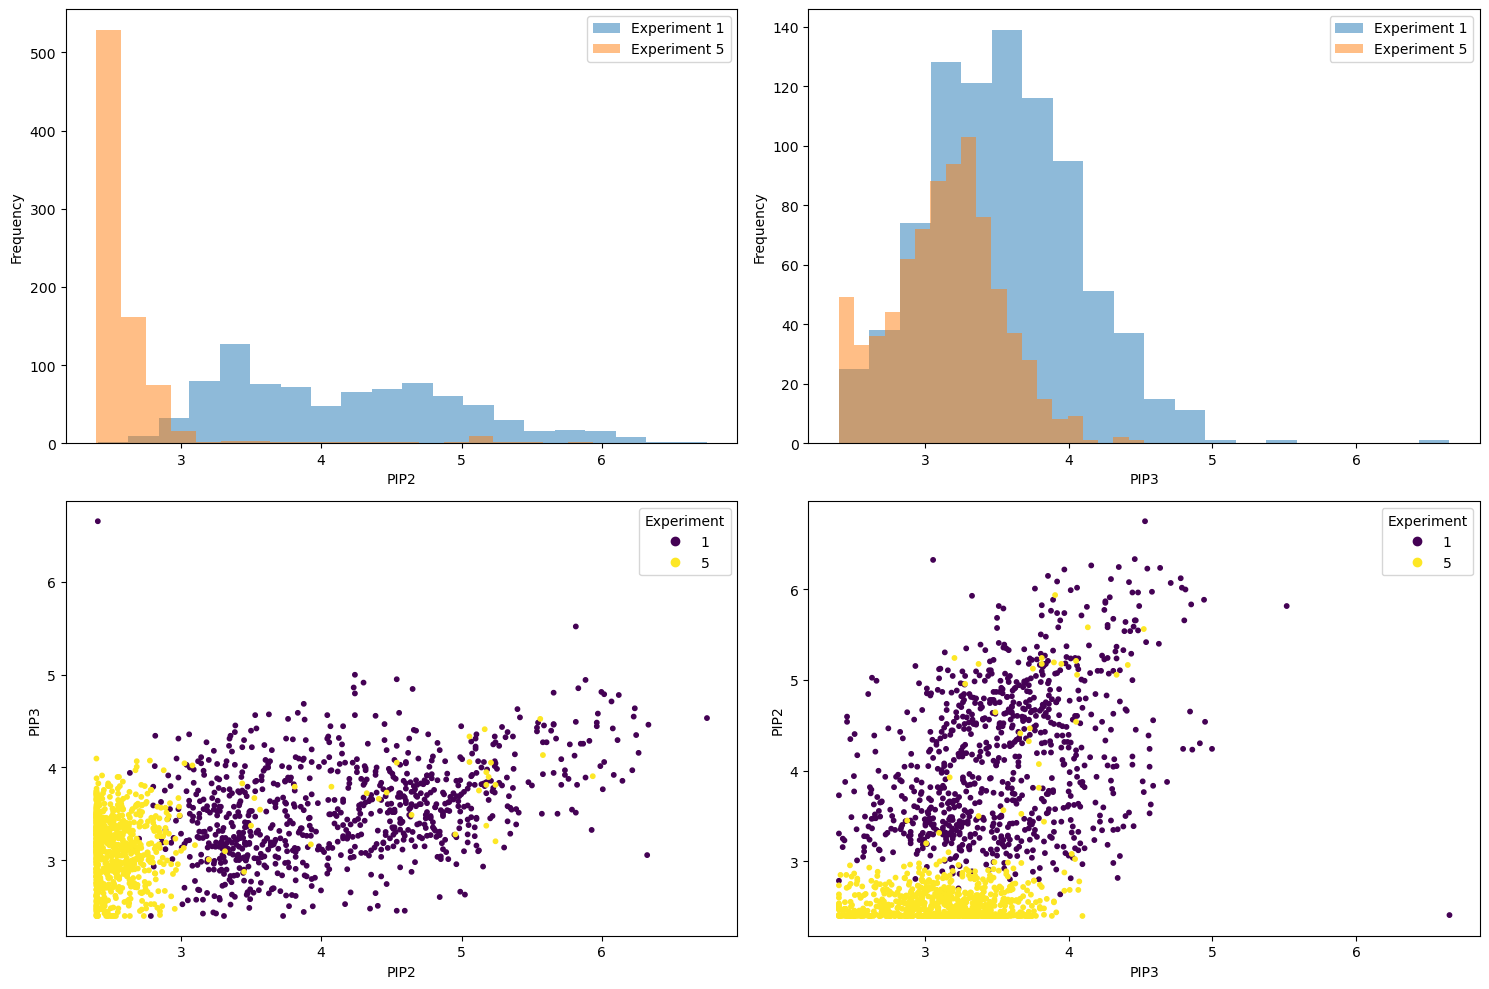

In [87]:
import matplotlib.pyplot as plt 

experiment_1_data = psitectorigenin_data[psitectorigenin_data['experiment'] == 1]
experiment_5_data = psitectorigenin_data[psitectorigenin_data['experiment'] == 5]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(experiment_1_data['PIP2'], alpha=0.5, label='Experiment 1', bins=20)
axes[0, 0].hist(experiment_5_data['PIP2'], alpha=0.5, label='Experiment 5', bins=20)
axes[0, 0].set_xlabel('PIP2')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

axes[0, 1].hist(experiment_1_data['PIP3'], alpha=0.5, label='Experiment 1', bins=20)
axes[0, 1].hist(experiment_5_data['PIP3'], alpha=0.5, label='Experiment 5', bins=20)
axes[0, 1].set_xlabel('PIP3')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

scatter_pip2 = axes[1, 0].scatter(psitectorigenin_data['PIP2'], psitectorigenin_data['PIP3'], c=psitectorigenin_data["experiment"], s=10)
axes[1, 0].set_xlabel('PIP2')
axes[1, 0].set_ylabel('PIP3')
axes[1, 0].legend(*scatter_pip2.legend_elements(), title="Experiment")

scatter_pip3 = axes[1, 1].scatter(psitectorigenin_data['PIP3'], psitectorigenin_data['PIP2'], c=psitectorigenin_data["experiment"], s=10)
axes[1, 1].set_xlabel('PIP3')
axes[1, 1].set_ylabel('PIP2')
axes[1, 1].legend(*scatter_pip3.legend_elements(), title="Experiment")

plt.tight_layout()
plt.show()


**Question (1.5 points)**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables adjacent to pmek in the output of PC. Assume it is true that adding U0126 produces an intervention on the *activity* of pmek. What would you expect to see in the data if the graph found by PC was correct? Would you propose any changes to that graph based on the data?

Again put your answer (about 200 words) with accompanying plots in new boxes below here.

If the graph found by the PC algorithm was correct, I would expect to see no changes in the data since pmek has no children. Thus, causing an increase in its activity would not result in changes in other variables. (I am unsure what the values in the dataset represent. If they represent activity, I would expect that upon the addition of U0126, pmek values would increase, as we see in the data. However, if they represent amount of protein, I would expect that the addition of U0126 would not change the values of pmek, conversely to the data.). 

However, when looking at the data, we see a decrease in perk values upon addition of U0126. This is unexpected given the graph, since there is no edge between pmek and perk. In fact they are in two different components. I would propose a change to the graph by inserting a directed edge between pmek and perk in the direction of perk.

Additionally, we see an increase in praf values when adding U0126. When we assume that it is true that adding this compound produces an intervention on the activity of pmek, I propose to reverse the edge between praf and pmek to be in the direction of praf.

Finally, the intervention has no effect on PIP3, so that edge is likely correct and should remain unchanged.


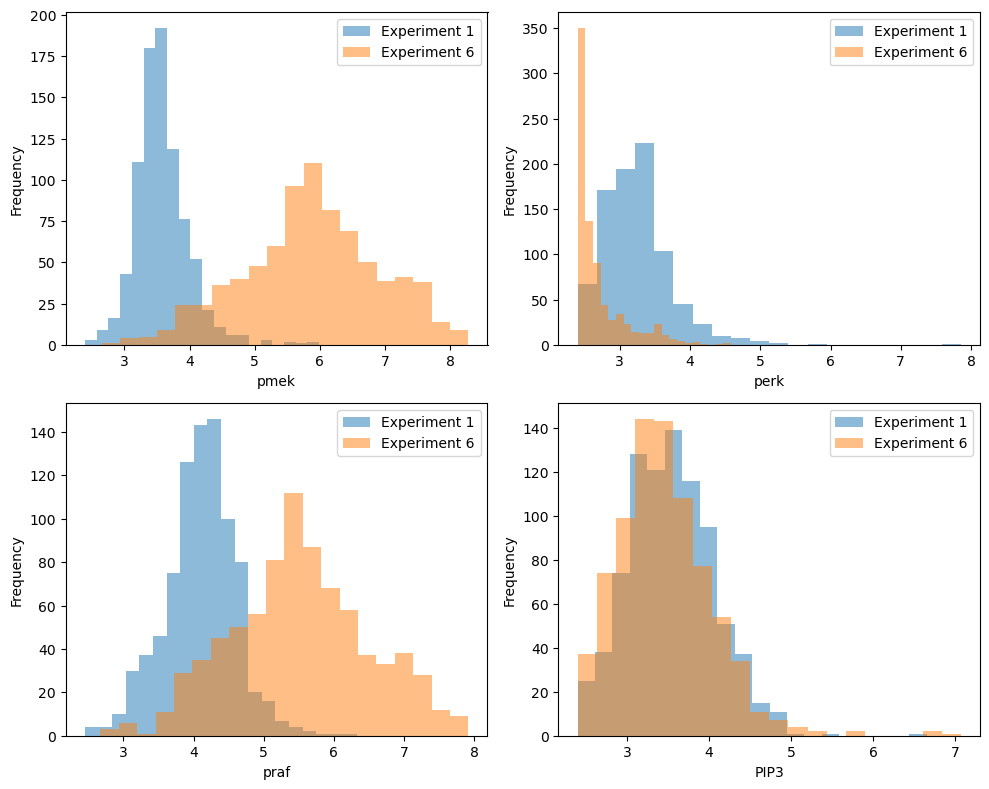

In [83]:
experiment_6_data = U0126_data[U0126_data['experiment'] == 6]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].hist(experiment_1_data['pmek'], alpha=0.5, label='Experiment 1', bins=20)
axes[0, 0].hist(experiment_6_data['pmek'], alpha=0.5, label='Experiment 6', bins=20)
axes[0, 0].set_xlabel('pmek')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
#experiment increase pmek values.

axes[0, 1].hist(experiment_1_data['perk'], alpha=0.5, label='Experiment 1', bins=20)
axes[0, 1].hist(experiment_6_data['perk'], alpha=0.5, label='Experiment 6', bins=20)
axes[0, 1].set_xlabel('perk')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
#experiment decreases perk values.

axes[1, 0].hist(experiment_1_data['praf'], alpha=0.5, label='Experiment 1', bins=20)
axes[1, 0].hist(experiment_6_data['praf'], alpha=0.5, label='Experiment 6', bins=20)
axes[1, 0].set_xlabel('praf')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
#experiment increases praf values.

axes[1, 1].hist(experiment_1_data['PIP3'], alpha=0.5, label='Experiment 1', bins=20)
axes[1, 1].hist(experiment_6_data['PIP3'], alpha=0.5, label='Experiment 6', bins=20)
axes[1, 1].set_xlabel('PIP3')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
#not really a change in PIP3 values.

plt.tight_layout()
plt.show()


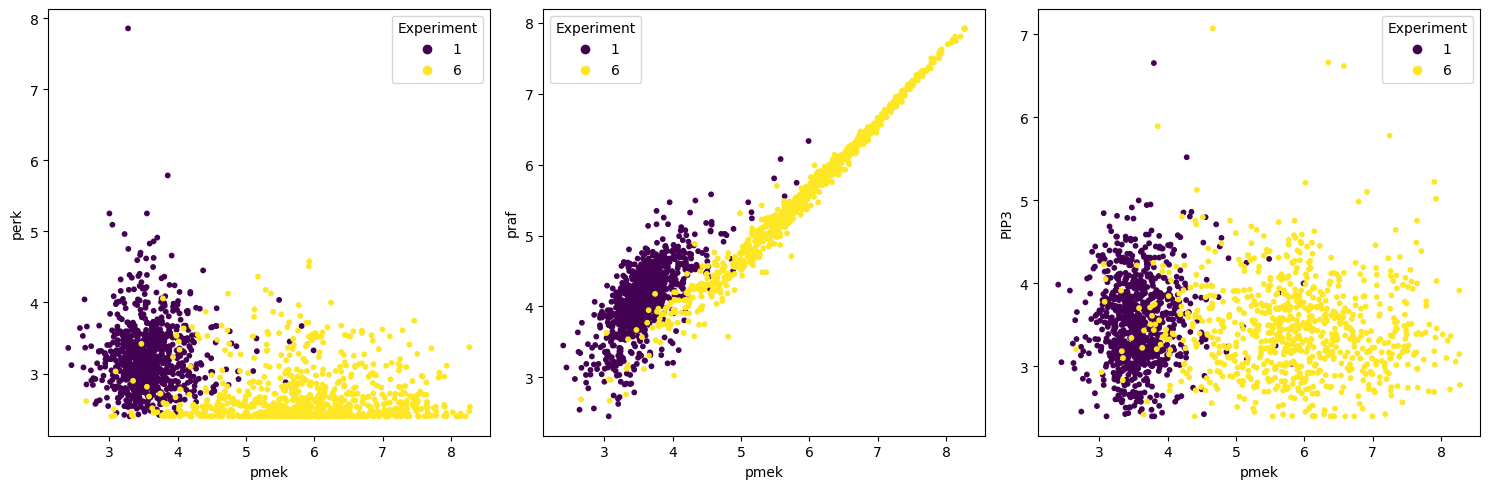

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

perk_scatter = axes[0].scatter(U0126_data['pmek'], U0126_data['perk'], c=U0126_data["experiment"], s=10)
axes[0].set_xlabel('pmek')
axes[0].set_ylabel('perk')
axes[0].legend(*perk_scatter.legend_elements(), title="Experiment")

praf_scatter = axes[1].scatter(U0126_data['pmek'], U0126_data['praf'], c=U0126_data["experiment"], s=10)
axes[1].set_xlabel('pmek')
axes[1].set_ylabel('praf')
axes[1].legend(*praf_scatter.legend_elements(), title="Experiment")

PIP3_scatter = axes[2].scatter(U0126_data['pmek'], U0126_data['PIP3'], c=U0126_data["experiment"], s=10)
axes[2].set_xlabel('pmek')
axes[2].set_ylabel('PIP3')
axes[2].legend(*PIP3_scatter.legend_elements(), title="Experiment")

plt.tight_layout()
plt.show()

---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.